
Results for 0.0% synthetic data:
    Dataset  Accuracy    Recall  Precision  F1-score
0  Training  0.744767  0.507414   0.687500  0.583886
1      Test  0.538462  0.202614   0.289720  0.238462
2  Original  0.703583  0.446053   0.610811  0.515589


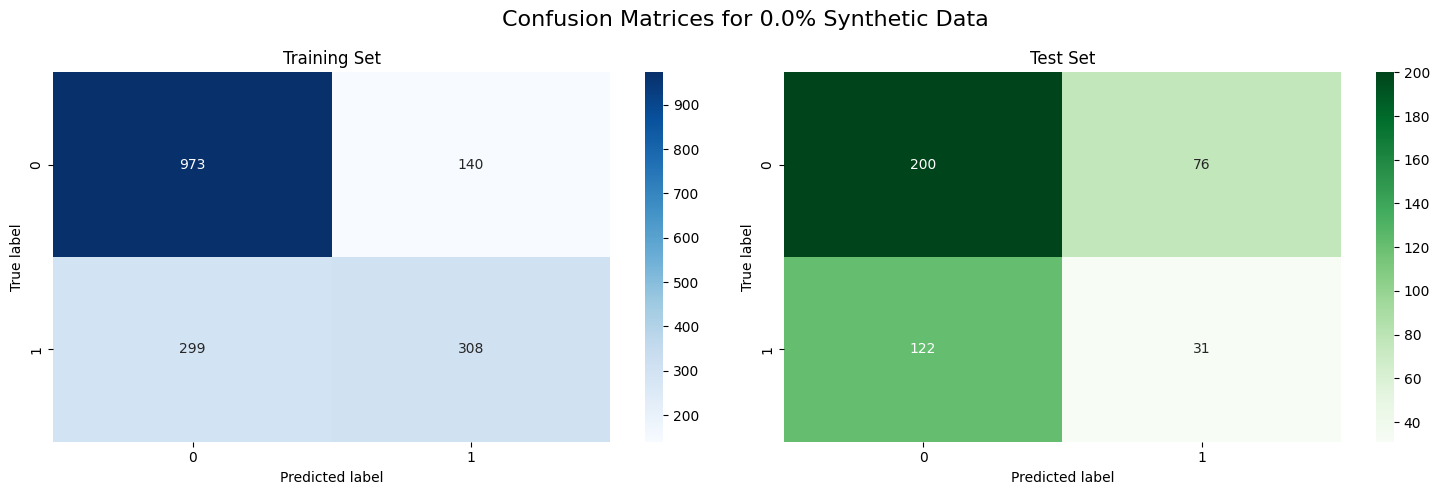

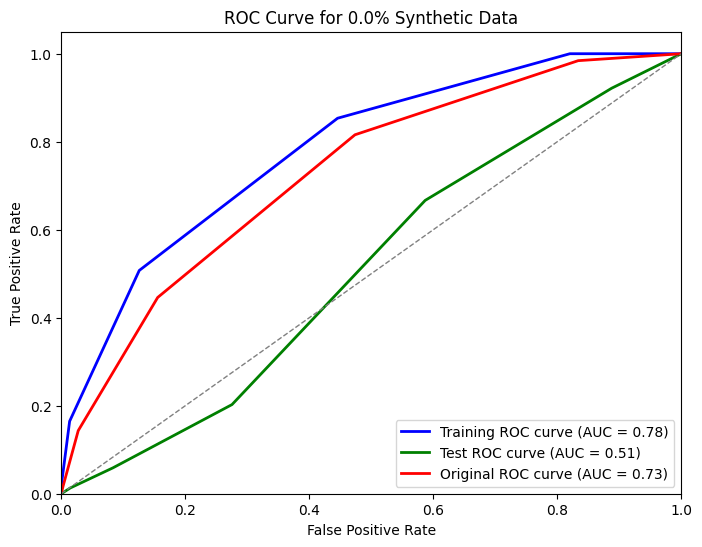


Results for 20.0% synthetic data:
    Dataset  Accuracy    Recall  Precision  F1-score
0  Training  0.727358  0.477089   0.650735  0.550544
1      Test  0.578089  0.260000   0.357798  0.301158
2  Original  0.707771  0.452632   0.618705  0.522796


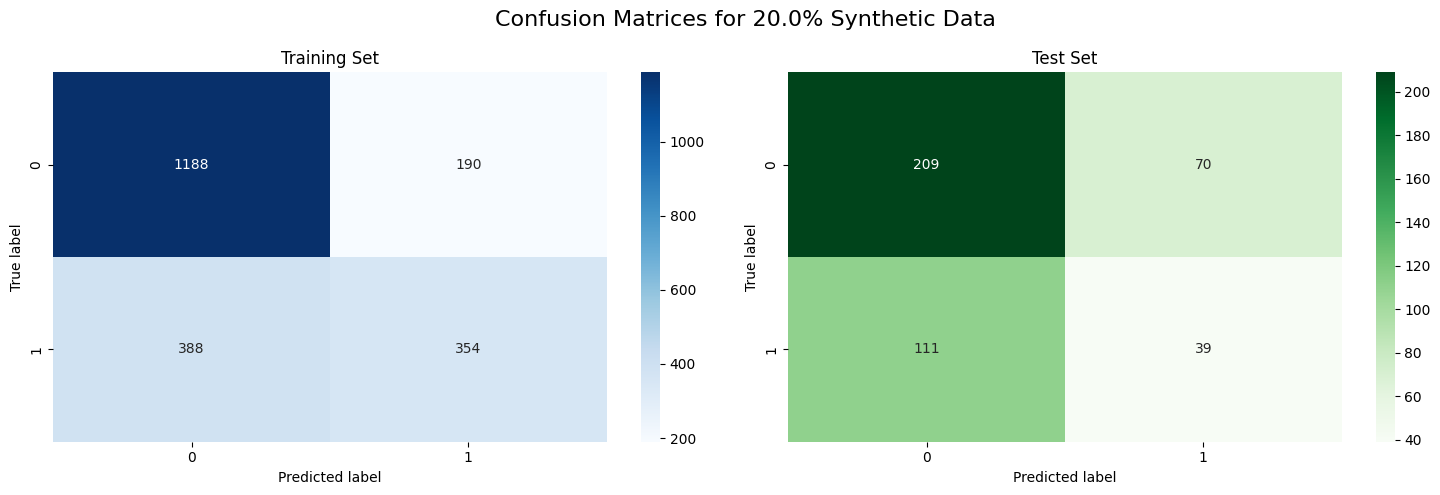

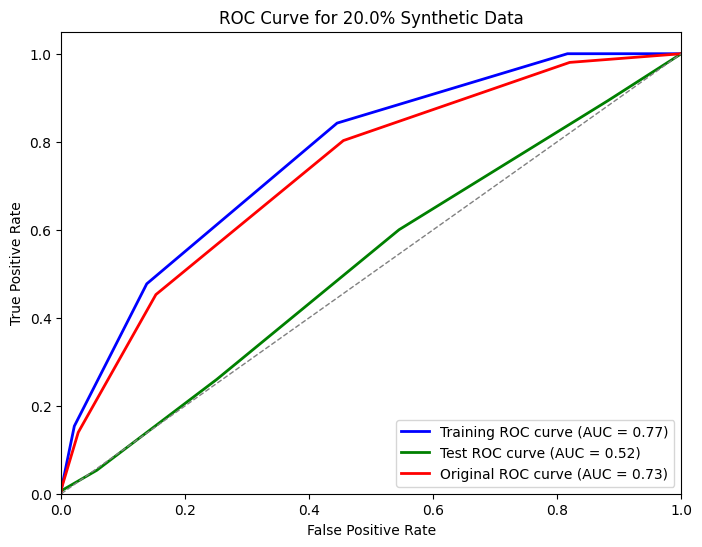


Results for 40.0% synthetic data:
    Dataset  Accuracy    Recall  Precision  F1-score
0  Training  0.730952  0.469248   0.660256  0.548602
1      Test  0.566434  0.237762   0.306306  0.267717
2  Original  0.708236  0.435526   0.625709  0.513576


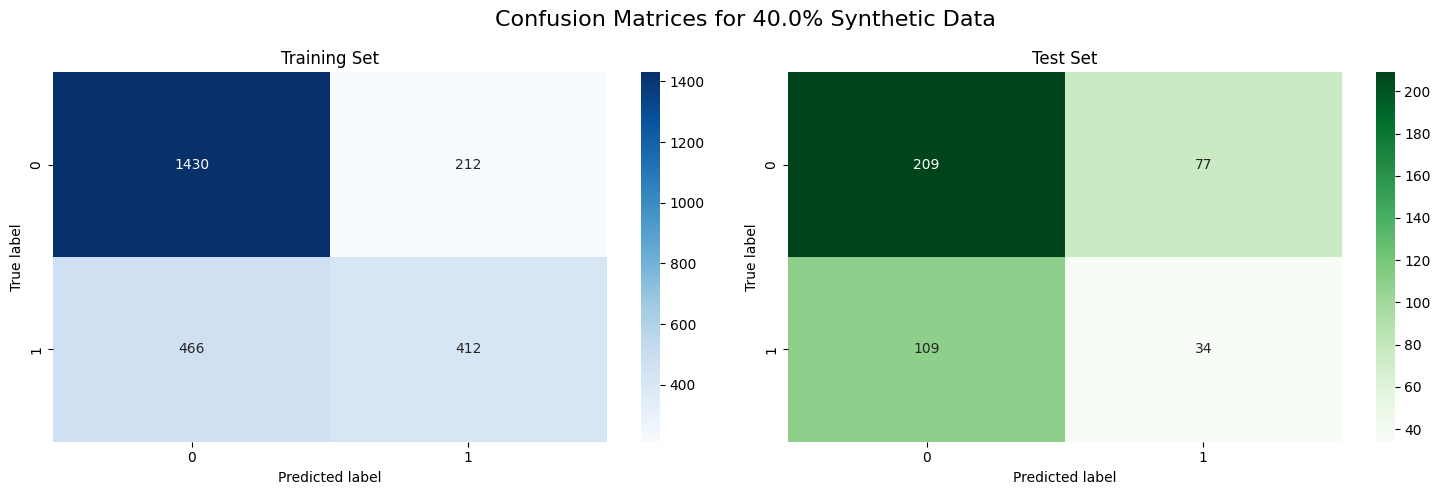

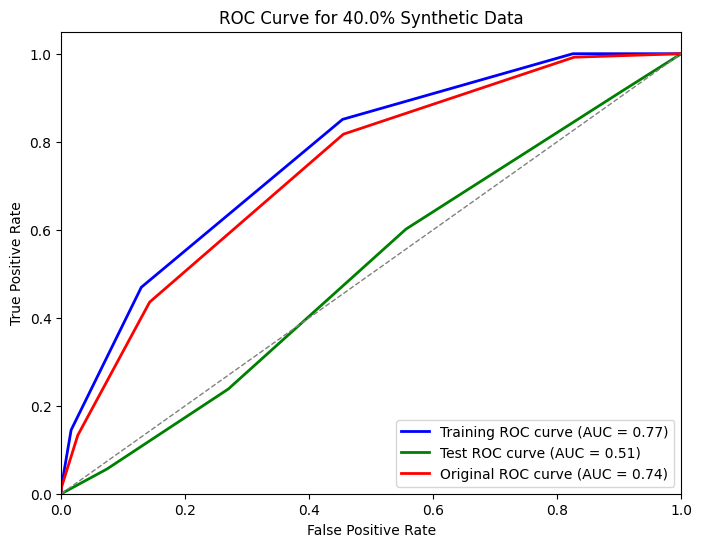


Results for 60.0% synthetic data:
    Dataset  Accuracy    Recall  Precision  F1-score
0  Training  0.730822  0.465000   0.649441  0.541958
1      Test  0.613054  0.234043   0.362637  0.284483
2  Original  0.711494  0.448684   0.629151  0.523810


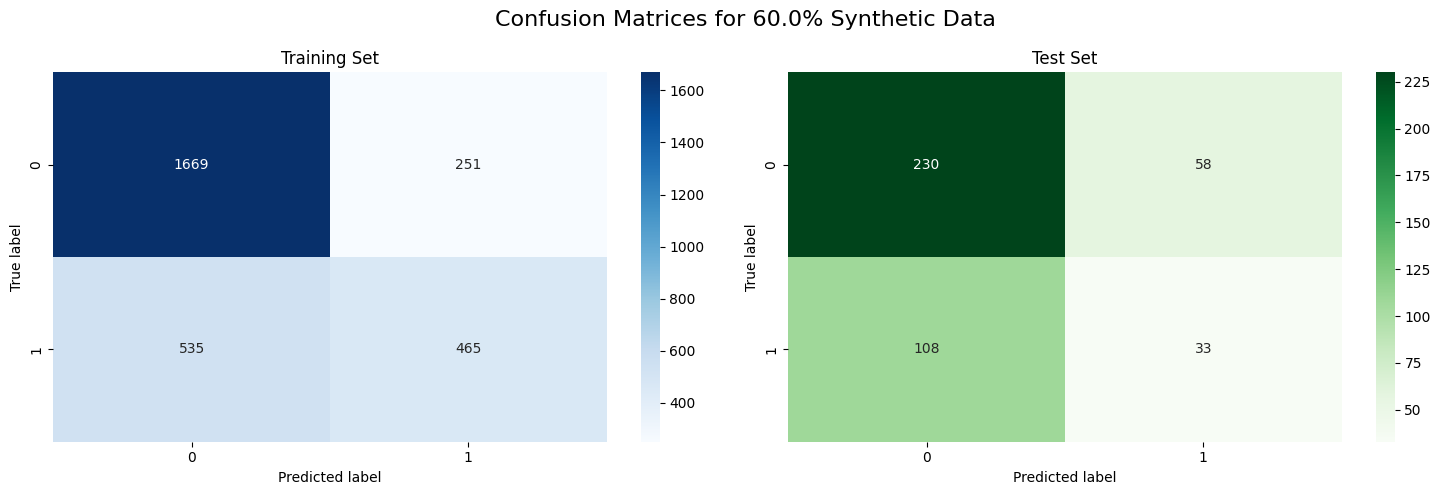

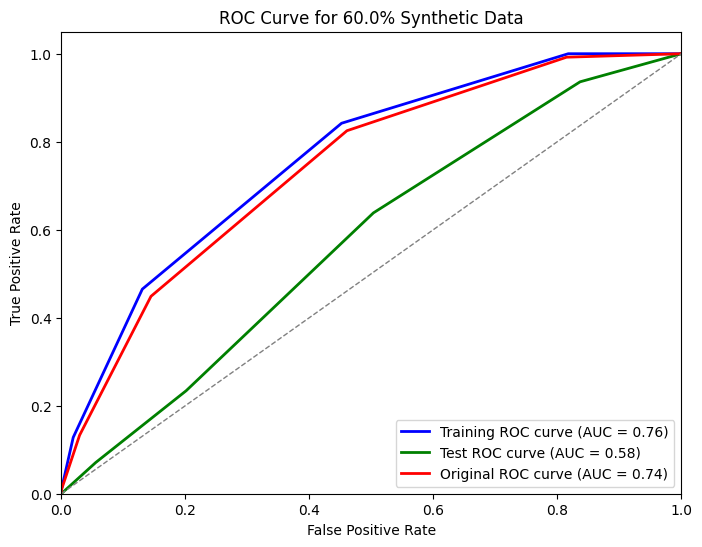


Results for 80.0% synthetic data:
    Dataset  Accuracy    Recall  Precision  F1-score
0  Training  0.729819  0.460674   0.661290  0.543046
1      Test  0.606061  0.330882   0.365854  0.347490
2  Original  0.715682  0.459211   0.635701  0.533231


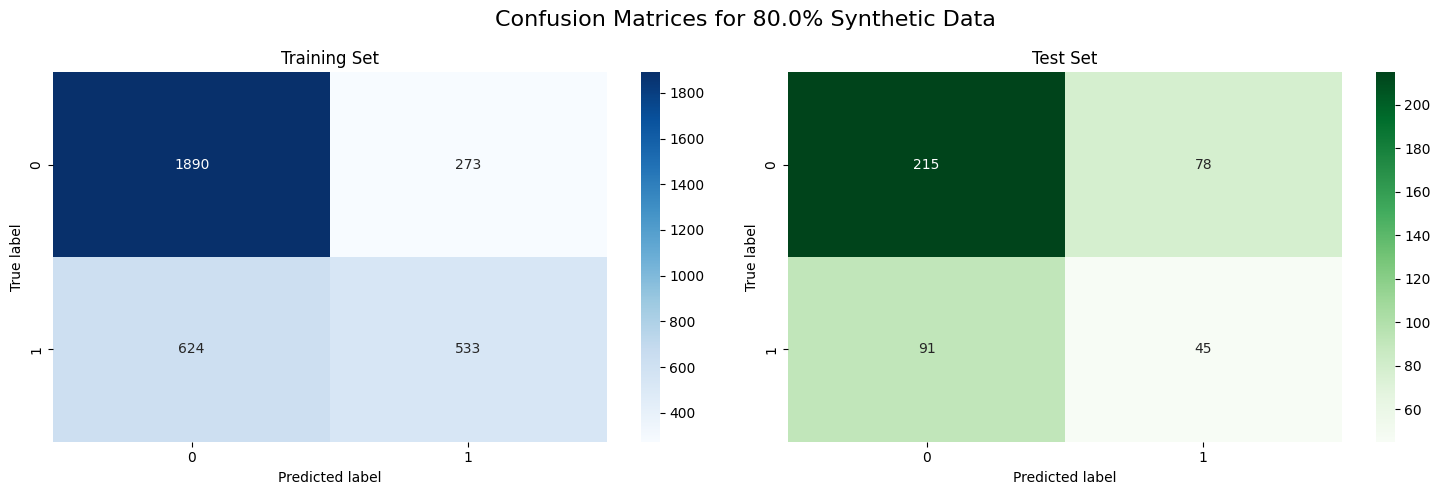

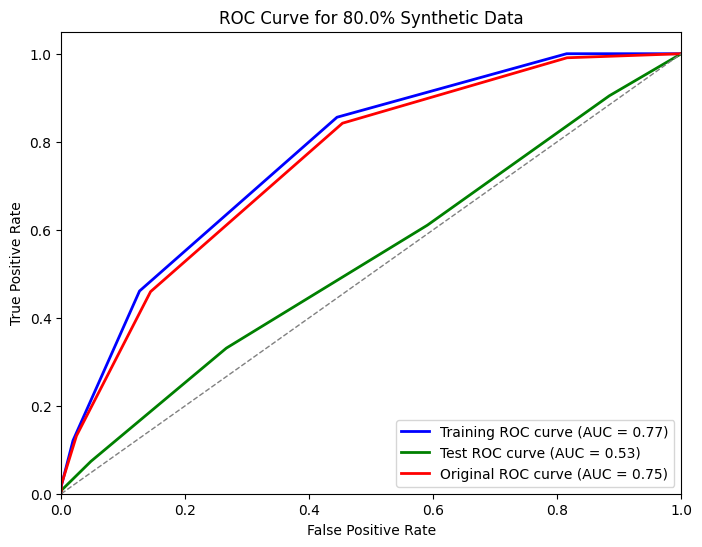


Results for 100.0% synthetic data:
    Dataset  Accuracy    Recall  Precision  F1-score
0  Training  0.731183  0.471184   0.653348  0.547511
1      Test  0.575758  0.191489   0.284211  0.228814
2  Original  0.718474  0.465789   0.640145  0.539223


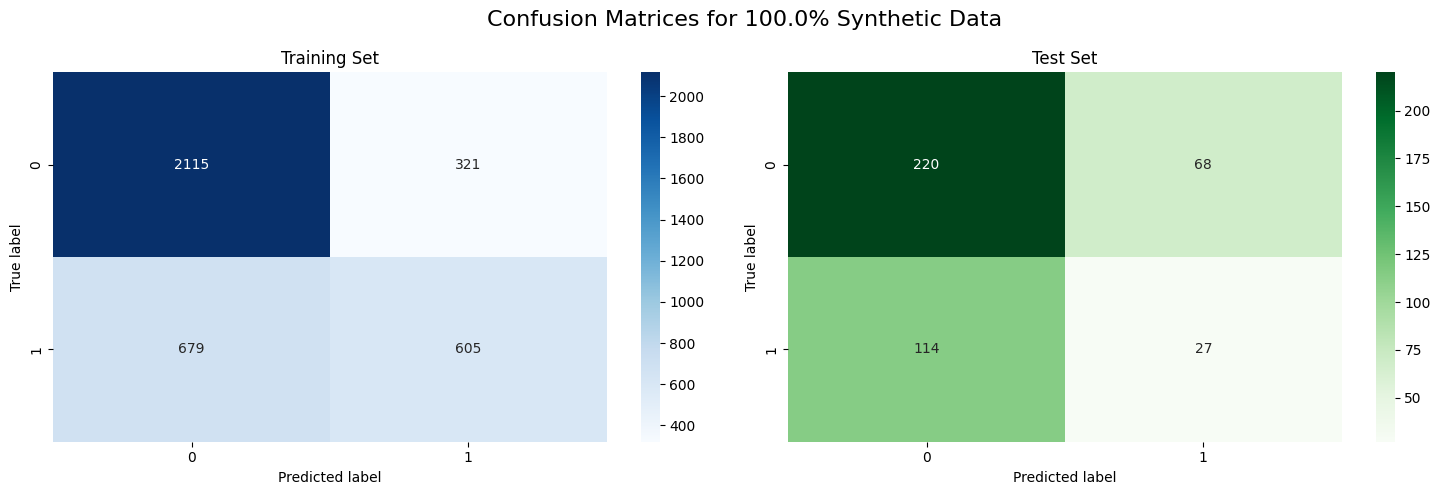

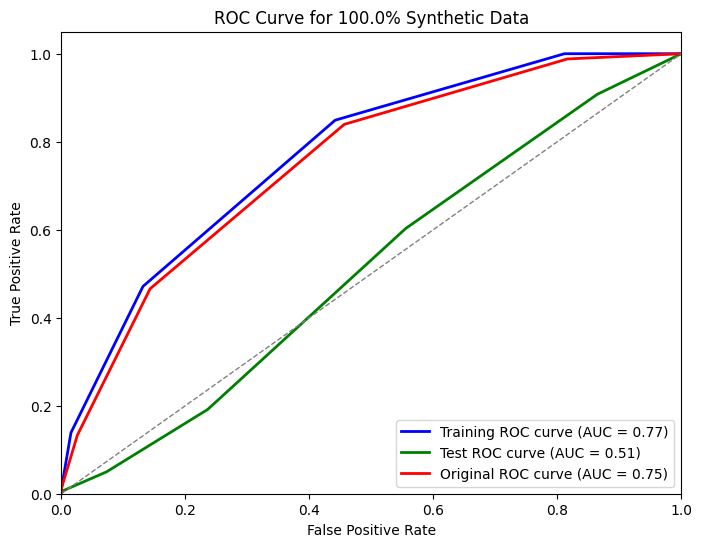

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier

# Load datasets
synthetic_data_path = '../datasets/tabular/generated/alzheimers_disease_genereted.csv'
synthetic_data = pd.read_csv(synthetic_data_path)

original_data_path = '../datasets/tabular/original/alzheimers_disease_data.csv'
original_data = pd.read_csv(original_data_path)

# Drop unnecessary columns
synthetic_data = synthetic_data.drop(columns=['PatientID', 'DoctorInCharge'], errors='ignore')
original_data = original_data.drop(columns=['PatientID', 'DoctorInCharge'], errors='ignore')

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'F1-score': f1_score(y_true, y_pred)
    }

# Define percentages of synthetic data to use (including 0% synthetic data)
percentages = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

# Iterate through each percentage
for percentage in percentages:
    print(f"\nResults for {percentage*100}% synthetic data:")
    
    # Calculate number of synthetic samples to use
    n_synthetic = int(len(synthetic_data) * percentage)
    
    # Combine data: Add synthetic data to the end of the training set
    combined_data = pd.concat([original_data, synthetic_data.iloc[:n_synthetic]], ignore_index=True)
    combined_data = shuffle(combined_data, random_state=42)
    
    # Prepare features and target
    X = combined_data.drop(columns=['Diagnosis'])
    y = combined_data['Diagnosis']
    
    # Manually split data: first 20% of the entire dataset is for testing
    split_point = int(0.2 * len(original_data))  # Split point based only on original data size
    
    X_test, X_train = X[:split_point], X[split_point:]
    y_test, y_train = y[:split_point], y[split_point:]
    
    # Train KNN classifier
    model = KNeighborsClassifier()
    model.fit(X_train, y_train)
    
    # Calculate metrics for training set
    y_train_pred = model.predict(X_train)
    train_metrics = calculate_metrics(y_train, y_train_pred)
    
    # Calculate metrics for test set
    y_test_pred = model.predict(X_test)
    test_metrics = calculate_metrics(y_test, y_test_pred)
    
    # Calculate metrics for original dataset
    X_original = original_data.drop(columns=['Diagnosis'])
    y_original = original_data['Diagnosis']
    y_original_pred = model.predict(X_original)
    original_metrics = calculate_metrics(y_original, y_original_pred)
    
    # Create DataFrame with results
    results = pd.DataFrame({
        'Dataset': ['Training', 'Test', 'Original'],
        'Accuracy': [train_metrics['Accuracy'], test_metrics['Accuracy'], original_metrics['Accuracy']],
        'Recall': [train_metrics['Recall'], test_metrics['Recall'], original_metrics['Recall']],
        'Precision': [train_metrics['Precision'], test_metrics['Precision'], original_metrics['Precision']],
        'F1-score': [train_metrics['F1-score'], test_metrics['F1-score'], original_metrics['F1-score']]
    })
    
    # Print results
    print(results)
    
    # Plot confusion matrices
    train_cm = confusion_matrix(y_train, y_train_pred)
    test_cm = confusion_matrix(y_test, y_test_pred)
    
    # Plot confusion matrices for current percentage
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'Confusion Matrices for {percentage*100}% Synthetic Data', fontsize=16)
    
    datasets = ['Training', 'Test', 'Original']
    colors = ['Blues', 'Greens', 'Reds']
    
    for i, (cm, dataset) in enumerate(zip([train_cm, test_cm], datasets)):
        sns.heatmap(cm, annot=True, fmt='d', cmap=colors[i], ax=axes[i])
        axes[i].set_title(f'{dataset} Set')
        axes[i].set_ylabel('True label')
        axes[i].set_xlabel('Predicted label')

    plt.tight_layout()
    plt.show()
    
    # Plot ROC curves
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Calculate ROC curve for training set
    y_train_prob = model.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
    roc_auc_train = auc(fpr_train, tpr_train)
    plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Training ROC curve (AUC = {roc_auc_train:.2f})')
    
    # Calculate ROC curve for test set
    y_test_prob = model.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
    roc_auc_test = auc(fpr_test, tpr_test)
    plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
    
    # Calculate ROC curve for original dataset
    y_original_prob = model.predict_proba(X_original)[:, 1]
    fpr_original, tpr_original, _ = roc_curve(y_original, y_original_prob)
    roc_auc_original = auc(fpr_original, tpr_original)
    plt.plot(fpr_original, tpr_original, color='red', lw=2, label=f'Original ROC curve (AUC = {roc_auc_original:.2f})')
    
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {percentage*100}% Synthetic Data')
    plt.legend(loc='lower right')
    plt.show()


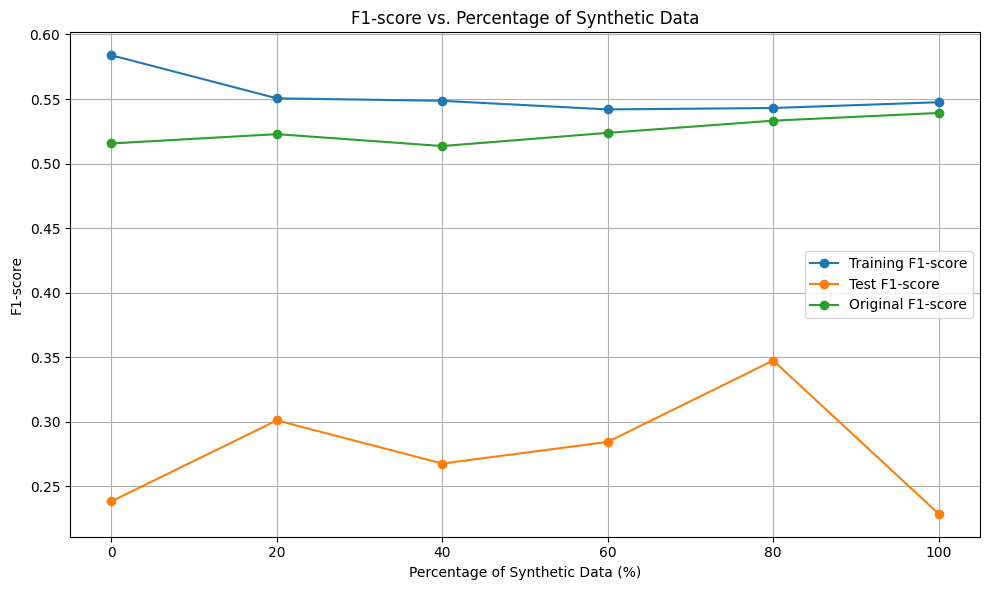

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier

# Load datasets
synthetic_data_path = '../datasets/tabular/generated/alzheimers_disease_genereted.csv'
synthetic_data = pd.read_csv(synthetic_data_path)

original_data_path = '../datasets/tabular/original/alzheimers_disease_data.csv'
original_data = pd.read_csv(original_data_path)

# Drop unnecessary columns
synthetic_data = synthetic_data.drop(columns=['PatientID', 'DoctorInCharge'], errors='ignore')
original_data = original_data.drop(columns=['PatientID', 'DoctorInCharge'], errors='ignore')

# Define percentages of synthetic data to use (including 0% synthetic data)
percentages = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

# Lists to store F1 scores for each dataset
f1_train_scores = []
f1_test_scores = []
f1_original_scores = []

# Iterate through each percentage
for percentage in percentages:
    # Calculate number of synthetic samples to use
    n_synthetic = int(len(synthetic_data) * percentage)
    
    # Combine data: Add synthetic data to the end of the training set
    combined_data = pd.concat([original_data, synthetic_data.iloc[:n_synthetic]], ignore_index=True)
    combined_data = shuffle(combined_data, random_state=42)
    
    # Prepare features and target
    X = combined_data.drop(columns=['Diagnosis'])
    y = combined_data['Diagnosis']
    
    # Manually split data: first 20% of the entire dataset is for testing
    split_point = int(0.2 * len(original_data))  # Split point based only on original data size
    
    X_test, X_train = X[:split_point], X[split_point:]
    y_test, y_train = y[:split_point], y[split_point:]
    
    # Train KNN classifier
    model = KNeighborsClassifier()
    model.fit(X_train, y_train)
    
    # Calculate F1 scores for training set, test set, and original dataset
    y_train_pred = model.predict(X_train)
    f1_train_scores.append(f1_score(y_train, y_train_pred))
    
    y_test_pred = model.predict(X_test)
    f1_test_scores.append(f1_score(y_test, y_test_pred))
    
    X_original = original_data.drop(columns=['Diagnosis'])
    y_original = original_data['Diagnosis']
    y_original_pred = model.predict(X_original)
    f1_original_scores.append(f1_score(y_original, y_original_pred))

# Plot F1 scores
plt.figure(figsize=(10, 6))
plt.plot([p * 100 for p in percentages], f1_train_scores, label='Training F1-score', marker='o')
plt.plot([p * 100 for p in percentages], f1_test_scores, label='Test F1-score', marker='o')
plt.plot([p * 100 for p in percentages], f1_original_scores, label='Original F1-score', marker='o')

plt.xlabel('Percentage of Synthetic Data (%)')
plt.ylabel('F1-score')
plt.title('F1-score vs. Percentage of Synthetic Data')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
